In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
from folic_acid_mult_model_fns import *

In [4]:
# SET GLOBALS
location_ids = [163,214,179] # India, Nigeria, Ethiopia

ages = [1,2,3,4,5] # U5, early neonatal, late neonatal, post neonatal, 1 to 4 
sexes = [1,2] # M,F

index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [5]:
rei_id = [] #folic acid doesn't affect any risks; just NTDs
cause_ids = [642] # NTD YLLs
nonfatal_causes = [642] # NTD YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [6]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
# rr_distribution = lognorm(s=sigma, scale=median)

In [7]:
# pull table of rr for no fortification distribution
rr_ntds_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
179    1.712028
dtype: float64

In [8]:
# pull current coverage (alpha), and coverage ceiling (alpha_star)
alpha, alpha_star = generate_overall_coverage_rates(nutrient,
                                                    vehicle,
                                                    alternative_scenario_coverage_levels,
                                                    years = [2021,2022,2023,2024,2025],
                                                    location_ids = location_ids)

In [9]:
# subset / reshape
alpha = alpha.reset_index()
alpha = alpha[alpha.year==2021]
alpha = alpha.drop(columns='year').set_index('location_id')

coverage_defn_labels = {0.2:'low',0.5:'medium',0.8:'high'}
alpha_star = alpha_star.reset_index()
alpha_star.coverage_level = alpha_star.coverage_level.map(coverage_defn_labels)
alpha_star = alpha_star[alpha_star.year==2024].drop(columns='year').set_index(['location_id','coverage_level'])

In [10]:
# get change in coverage
delta_alpha = alpha_star - alpha
prop_averted_ntds = delta_alpha * (1-1/rr_ntds_nofort)

In [11]:
# dalys attributable to NTDs
dalys = pull_dalys(cause_ids,
                   nonfatal_cause_ids = cause_ids,
                   location_ids = location_ids,
                   ages = ages,
                   sexes = sexes,
                   index_cols = index_cols)

In [12]:
dalys = age_split_dalys(dalys)

In [13]:
dalys_averted = calc_dalys_averted(dalys, prop_averted_ntds)
dalys_contributed = dalys - dalys_averted

In [14]:
# add year_id to dataframe
dalys_averted = dalys_averted.reset_index().merge(pd.DataFrame({'cause_id':[642]*5,'year_id':[2021,2022,2023,2024,2025]}), how = 'left').set_index(['year_id','location_id','sex_id','age_group_id','cause_id','coverage_level'])

In [15]:
# which ages contribute dalys?
check_daly_distribution = dalys.reset_index()
check_daly_distribution = check_daly_distribution[check_daly_distribution.age_group_id.isin([2,3,4,49,50,51,52])].groupby(['location_id','age_group_id','cause_id']).sum().drop(columns=['sex_id'])

In [16]:
check_daly_distribution.mean(axis=1)

location_id  age_group_id  cause_id
163          2.0           642         470659.367410
             3.0           642          82184.601398
             4.0           642          96262.179608
             49.0          642           6244.500396
             50.0          642           6344.831147
             51.0          642           6457.449165
             52.0          642           6565.284121
179          2.0           642         113221.730809
             3.0           642          28713.797223
             4.0           642          67909.085695
             49.0          642           6105.839742
             50.0          642           5986.124616
             51.0          642           5886.477696
             52.0          642           5784.305745
214          2.0           642         500182.438372
             3.0           642         121682.815001
             4.0           642         450269.243796
             49.0          642          52518.463365
          

In [17]:
dalys_averted = is_affected(dalys_averted)

In [18]:
# set to zero if born too early for fortification
dalys_averted.loc[~dalys_averted.is_affected,[f'draw_{i}' for i in range(1_000)]] = 0

In [19]:
# subset to a disjoint set of ages and sum over age and sex
dalys_averted = dalys_averted[dalys_averted.age_group_id.isin([2,3,4,49,50,51,52])]

dalys_averted_u5 = dalys_averted.groupby(['year_id', 'location_id', 'cause_id', 'coverage_level']).sum().drop(columns=['age_group_id','sex_id'])

In [20]:
summary_absolute = dalys_averted_u5.reset_index().rename(columns={'year_id':'year'})

In [26]:
summary_absolute = summary_absolute.drop(columns=['cause_id','is_affected']).sort_values(['location_id','year','coverage_level'])

In [27]:
draws = [f'draw_{i}' for i in range(1_000)]

In [28]:
coverage_level_map = {'low': 0.2, 'medium': 0.5, 'high': 0.8}

In [29]:
summary_absolute.coverage_level = summary_absolute.coverage_level.map(coverage_level_map)

In [30]:
abs_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_dalys_averted_absolute.csv'
summary_absolute[['location_id','year','coverage_level'] + draws].to_csv(abs_save_path, index=False)

In [31]:
## convert to rate
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

summary_rate = summary_absolute.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

In [32]:
summary_rate
for i in draws:
    summary_rate[i] = (summary_rate[i] / summary_rate.population) * 100_000

In [33]:
summary_rate = summary_rate.drop(columns='population')[['location_id','year','coverage_level'] + draws]

In [34]:
rate_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_dalys_averted_rate.csv'
summary_rate.to_csv(rate_save_path, index = False)

In [35]:
dalys_u5 = dalys.reset_index()
dalys_u5 = dalys_u5[dalys_u5.age_group_id==1.0]

In [36]:
dalys_u5 = dalys_u5.groupby(['location_id']).sum()[draws]

In [37]:
summary_pif = summary_absolute.set_index(['year','location_id','coverage_level']) / dalys_u5

In [38]:
pif_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_pif.csv'
summary_pif.to_csv(pif_save_path)

In [40]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

In [42]:
dalys_averted_u5 = dalys_averted_u5.reset_index()

In [44]:
## convert to rate
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

In [45]:
dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [46]:
dalys_averted_u5.head()

,year_id,location_id,cause_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,2021,163,642,high,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
1,2021,163,642,low,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
2,2021,163,642,medium,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
3,2021,179,642,high,0.0,0.0,0.0,1.667967e+07,0.0,0.0,0.0
4,2021,179,642,low,0.0,0.0,0.0,1.667967e+07,0.0,0.0,0.0


# viz results

In [47]:
dalys_averted_u5.coverage_level.unique()

array(['high', 'low', 'medium'], dtype=object)

In [48]:
# coverage_defn_labels = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_defn_labels)

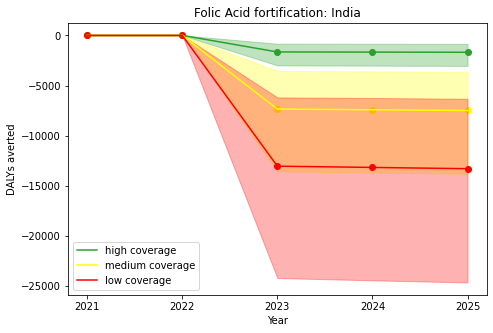

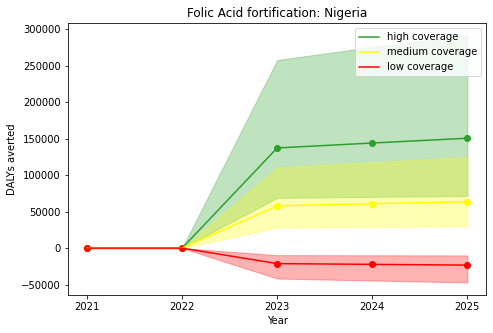

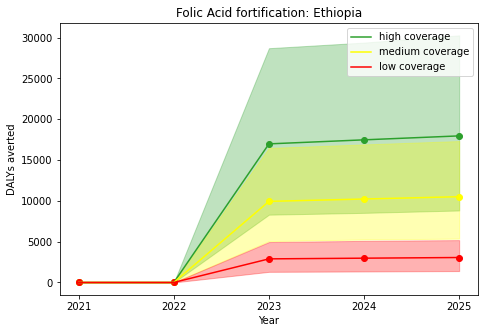

In [49]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


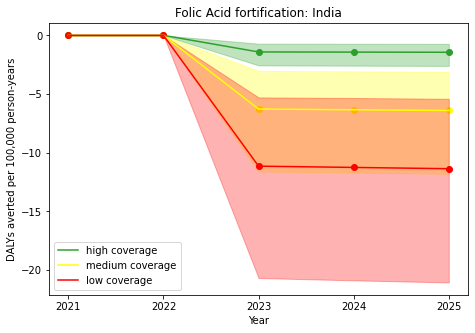

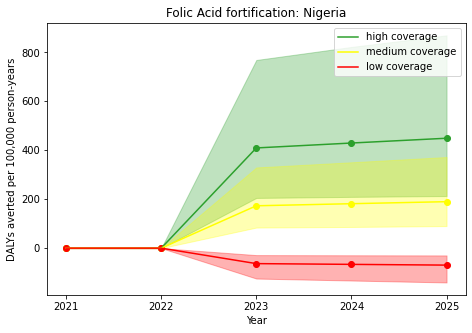

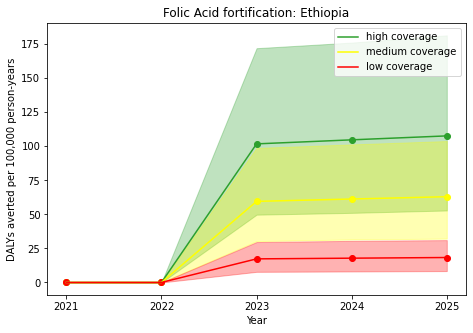

In [50]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


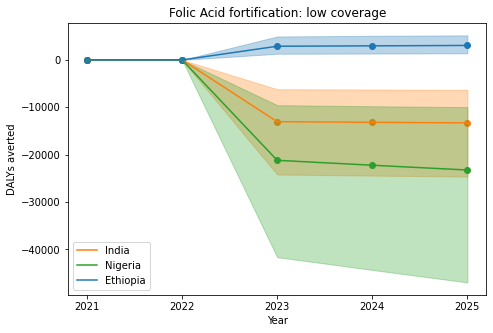

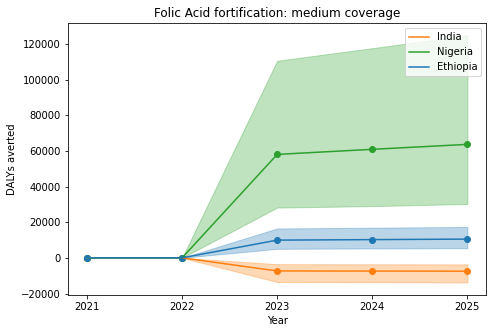

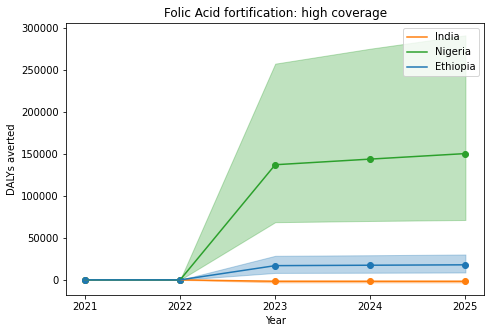

In [51]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


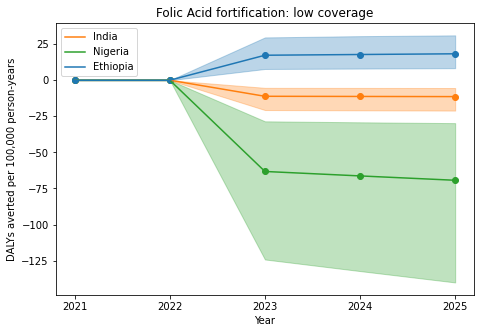

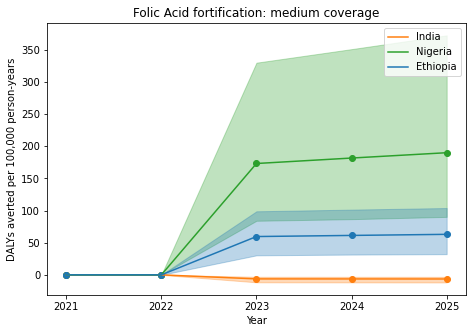

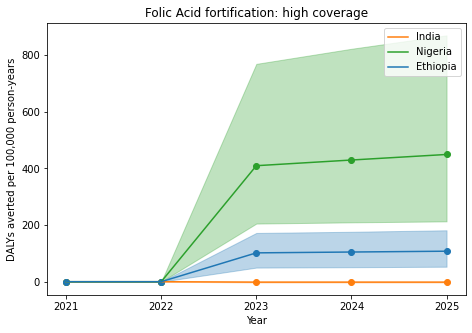

In [52]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)